# <center> ResNet50 </center>

# Data Loading

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

data_dir = '/input/skin-disease-roi-balanced-data/Classes_SMOTE2'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = []
        class_to_idx = {}
        for folder_name in sorted(os.listdir(directory)):
            if folder_name.startswith('ROI_'):
                class_name = folder_name.split('ROI_')[-1]
            else:
                class_name = folder_name
            classes.append(class_name)
            class_to_idx[folder_name] = len(classes) - 1
        return classes, class_to_idx

dataset = CustomImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ResNet50 Fine Tuning

In [ ]:
model = resnet50(pretrained=True)

num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    # Evaluation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_dataset)
    test_losses.append(epoch_loss)
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.2350
Epoch 1/15, Test Loss: 1.0947, Test Accuracy: 0.6079
Epoch 2/15, Train Loss: 0.8870
Epoch 2/15, Test Loss: 1.4573, Test Accuracy: 0.5961
Epoch 3/15, Train Loss: 0.7153
Epoch 3/15, Test Loss: 0.9160, Test Accuracy: 0.6709
Epoch 4/15, Train Loss: 0.6309
Epoch 4/15, Test Loss: 1.0769, Test Accuracy: 0.6661
Epoch 5/15, Train Loss: 0.5043
Epoch 5/15, Test Loss: 0.6285, Test Accuracy: 0.7717
Epoch 6/15, Train Loss: 0.4775
Epoch 6/15, Test Loss: 0.5327, Test Accuracy: 0.7984
Epoch 7/15, Train Loss: 0.3875
Epoch 7/15, Test Loss: 0.7056, Test Accuracy: 0.7677
Epoch 8/15, Train Loss: 0.3309
Epoch 8/15, Test Loss: 0.6469, Test Accuracy: 0.7646
Epoch 9/15, Train Loss: 0.3058
Epoch 9/15, Test Loss: 0.6885, Test Accuracy: 0.7866
Epoch 10/15, Train Loss: 0.2589
Epoch 10/15, Test Loss: 0.5912, Test Accuracy: 0.8173
Epoch 11/15, Train Loss: 0.2558
Epoch 11/15, Test Loss: 0.7513, Test Accuracy: 0.7654
Epoch 12/15, Train Loss: 0.1465
Epoch 12/15, Test Loss: 0.5967, Test Acc

# Evaluation Metrics

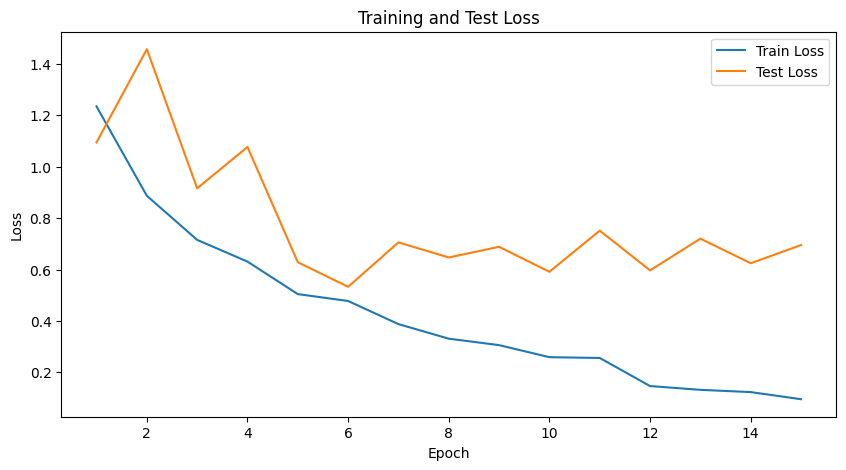

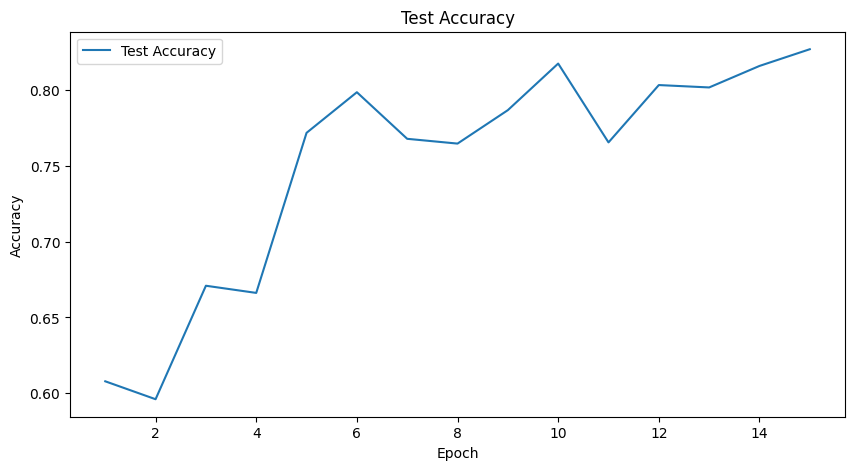

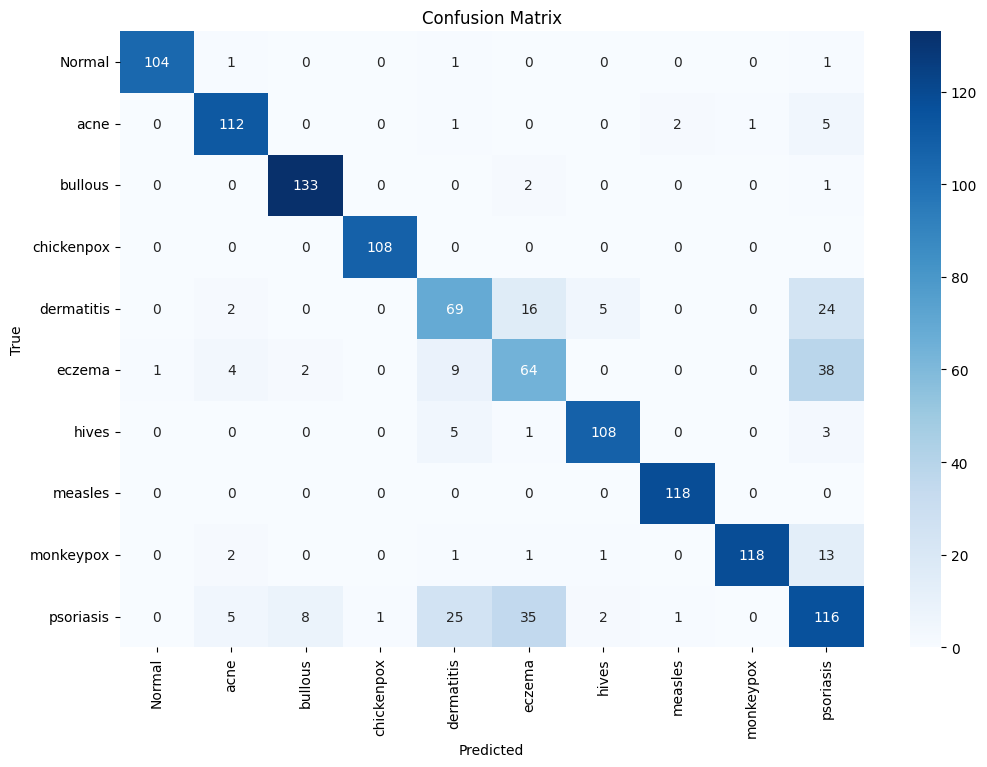

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       107
        acne       0.89      0.93      0.91       121
     bullous       0.93      0.98      0.95       136
  chickenpox       0.99      1.00      1.00       108
  dermatitis       0.62      0.59      0.61       116
      eczema       0.54      0.54      0.54       118
       hives       0.93      0.92      0.93       117
     measles       0.98      1.00      0.99       118
   monkeypox       0.99      0.87      0.93       136
   psoriasis       0.58      0.60      0.59       193

    accuracy                           0.83      1270
   macro avg       0.84      0.84      0.84      1270
weighted avg       0.83      0.83      0.83      1270



In [ ]:
# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", class_report)

# <center> Vision Transformer (ViT) </center>

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import timm

data_dir = '/input/skin-disease-roi-balanced-data/Classes_SMOTE2'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = []
        class_to_idx = {}
        for folder_name in sorted(os.listdir(directory)):
            if folder_name.startswith('ROI_'):
                class_name = folder_name.split('ROI_')[-1]
            else:
                class_name = folder_name
            classes.append(class_name)
            class_to_idx[folder_name] = len(classes) - 1
        return classes, class_to_idx

dataset = CustomImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(dataset.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    # Evaluation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_dataset)
    test_losses.append(epoch_loss)
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 2.5301
Epoch 1/20, Test Loss: 2.3564, Test Accuracy: 0.2000
Epoch 2/20, Train Loss: 1.9381
Epoch 2/20, Test Loss: 1.7980, Test Accuracy: 0.3732
Epoch 3/20, Train Loss: 1.7075
Epoch 3/20, Test Loss: 1.6849, Test Accuracy: 0.4252
Epoch 4/20, Train Loss: 1.5610
Epoch 4/20, Test Loss: 1.5124, Test Accuracy: 0.4835
Epoch 5/20, Train Loss: 1.4324
Epoch 5/20, Test Loss: 1.4040, Test Accuracy: 0.5236
Epoch 6/20, Train Loss: 1.3065
Epoch 6/20, Test Loss: 1.2518, Test Accuracy: 0.5740
Epoch 7/20, Train Loss: 1.2729
Epoch 7/20, Test Loss: 1.3035, Test Accuracy: 0.5354
Epoch 8/20, Train Loss: 1.1968
Epoch 8/20, Test Loss: 1.2997, Test Accuracy: 0.5425
Epoch 9/20, Train Loss: 1.1542
Epoch 9/20, Test Loss: 1.2468, Test Accuracy: 0.5661
Epoch 10/20, Train Loss: 1.2075
Epoch 10/20, Test Loss: 1.3927, Test Accuracy: 0.5205
Epoch 11/20, Train Loss: 1.0989
Epoch 11/20, Test Loss: 1.2537, Test Accuracy: 0.5520
Epoch 12/20, Train Loss: 1.0669
Epoch 12/20, Test Loss: 1.1398, Test Acc

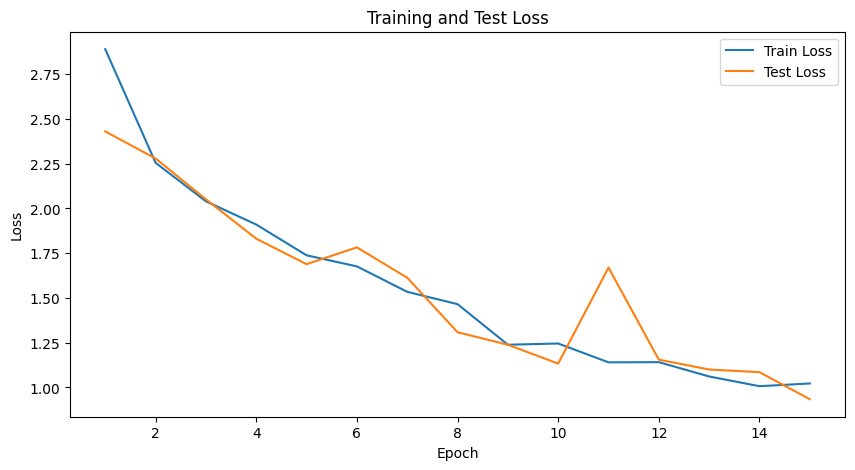

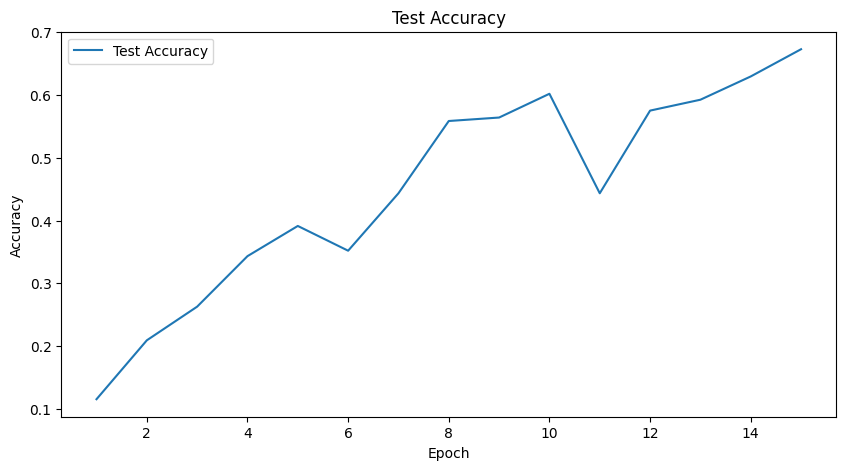

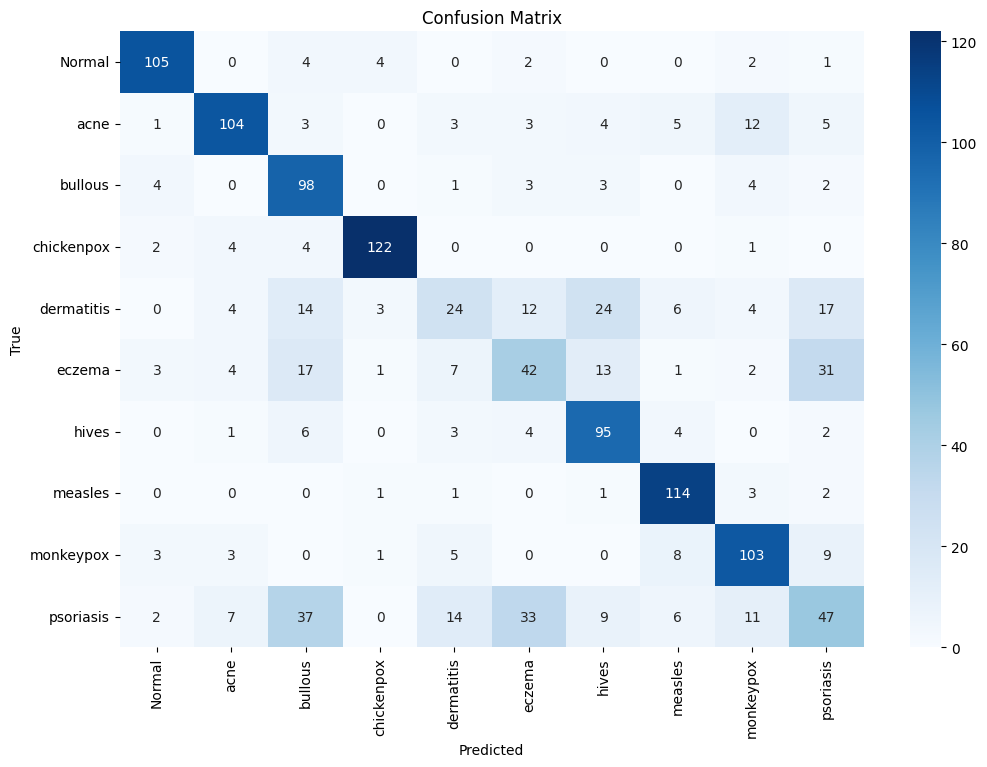

Classification Report:
               precision    recall  f1-score   support

      Normal       0.88      0.89      0.88       118
        acne       0.82      0.74      0.78       140
     bullous       0.54      0.85      0.66       115
  chickenpox       0.92      0.92      0.92       133
  dermatitis       0.41      0.22      0.29       108
      eczema       0.42      0.35      0.38       121
       hives       0.64      0.83      0.72       115
     measles       0.79      0.93      0.86       122
   monkeypox       0.73      0.78      0.75       132
   psoriasis       0.41      0.28      0.33       166

    accuracy                           0.67      1270
   macro avg       0.66      0.68      0.66      1270
weighted avg       0.65      0.67      0.65      1270



In [ ]:
# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", class_report)